In [1]:
import yfinance as yahooFinance
import pandas as pd
import numpy as np
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm 
import matplotlib.pyplot as plt

In [2]:
ticker_symbol = "^GSPC"
start_date = "2005-12-31"
end_date = "2010-12-31"
sp500_data = yahooFinance.download(ticker_symbol, start=start_date, end=end_date, interval="1d")
# sp500_data.to_excel('data.xlsx')

[*********************100%%**********************]  1 of 1 completed


In [3]:
sp500_data['Adjusted_Return'] = sp500_data['Adj Close'].pct_change()
sp500_data.drop(['Open','High','Low','Close','Volume'], inplace = True, axis = 1)

In [4]:
sp500_data['rolling_vol'] = sp500_data['Adjusted_Return'].rolling(window=10).std()
sp500_data.dropna(inplace = True)

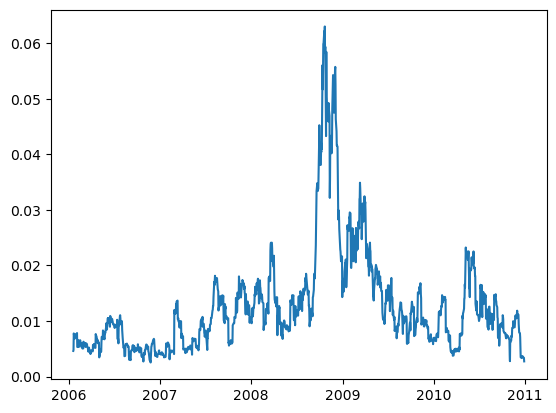

In [5]:
import matplotlib.pyplot as plt
plt.plot(sp500_data['rolling_vol'])
plt.show()

In [6]:
possible_strike = list(range(650, 1600 + 1, 25))
possible_strike = np.array(possible_strike)
print(possible_strike)

[ 650  675  700  725  750  775  800  825  850  875  900  925  950  975
 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325
 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600]


In [7]:
sp500_data['Time To Maturity'] = 1/12
sp500_data['Price Option'] = 0
sp500_data.drop('Adjusted_Return', axis = 1, inplace = True)

In [8]:
sp500_data

,Adj Close,rolling_vol,Time To Maturity,Price Option
Date,,,,
2006-01-18,1277.930054,0.004611,0.083333,0
2006-01-19,1285.040039,0.004781,0.083333,0
2006-01-20,1261.489990,0.007757,0.083333,0
2006-01-23,1263.819946,0.006969,0.083333,0
2006-01-24,1266.859985,0.006873,0.083333,0
...,...,...,...,...
2010-12-23,1256.770020,0.003686,0.083333,0
2010-12-27,1257.540039,0.003406,0.083333,0
2010-12-28,1258.510010,0.003382,0.083333,0


In [9]:
# Define the dimensions of your 4D array
num_call_or_put = ["Call","Put"]  # Call and Put
num_strike_prices = possible_strike
# date_index = date_arr
# num_rows_dates = len(date_arr)

for j,val in enumerate(num_strike_prices):
    sp500_data['Strike'] = np.array([val]*sp500_data.shape[0])
    sp500_data['Rf'] = np.array([0.5]*sp500_data.shape[0])
    sp500_data['Profit/Loss Options'] = np.array([0]*sp500_data.shape[0])
    sp500_data['Profit/Loss Spot'] = np.array([0]*sp500_data.shape[0])

ind = sp500_data.index
col = sp500_data.columns
    
num_rows, num_columns = sp500_data.shape    
    
# Create a 4D array to store the data
four_dimensional_array = np.zeros((len(num_call_or_put), len(num_strike_prices),num_rows, num_columns), dtype=object)

for i in range(len(num_call_or_put)):
    for j,val in enumerate(num_strike_prices):
        sp500_data['Strike'] = np.array([val]*num_rows)
        four_dimensional_array[i,j,:,:] = sp500_data

In [25]:
# # Dataframe input to BLM
# # def blackscholes(df, option_type)

# def blackscholes(df, option_type): 
#     S_t = df['Adj Close']
#     K = df['Strike']
#     r = df['Rf']
#     sigma = df['rolling_vol']
#     T_t = df['Time To Maturity']
#     # function to calculate d1 and d2 
    
#     def d1(S_t, K, r, sigma, T_t): 
#         return (np.log(S_t/K) + (r + 0.5*sigma**2)*T_t) / (sigma*np.sqrt(T_t)) 
#     def d2(d1, sigma, T_t): 
#         return d1 - sigma*np.sqrt(T_t) 
    
#     # Calculate d1, d2 and the Black-Scholes option price for each row in the dataframe     
#     df['d1'] = d1(S_t, K, r, sigma, T_t) 
#     df['d2'] = d2(df['d1'], sigma, T_t) 
#     df['Price Option'] = S_t*norm.cdf(df['d1']) - K*np.exp(-r*T_t*norm.cdf(df['d2'])) 
#     # Drop d1 and d2 columns 
#     df = df.drop(['d1', 'd2'], axis=1) 
#     return df

def calculate_pnl(df,option_type):
    if option_type == 'Call':
        df['Profit/Loss Options'] = -df['Price Option'].diff().fillna(0) * 100
    else:
        df['Profit/Loss Options'] = -df['Price Option'].diff().fillna(0) * 100
    df['Profit/Loss Spot'] = df['Adj Close'].diff().fillna(0) * 100
    return df

def blackscholes(df, option_type): 
    S_t = df['Adj Close']
    K = df['Strike']
    r = df['Rf']
    sigma = df['rolling_vol']
    T_t = df['Time To Maturity']
    def d1(S_t, K, r, sigma, T_t): 
        return (np.log(S_t / K) + (r + 0.5 * sigma**2) * T_t) / (sigma * np.sqrt(T_t)) 
    
    def d2(d1, sigma, T_t): 
        return d1 - sigma * np.sqrt(T_t) 
    
    # Calculate d1, d2, and the Black-Scholes option price for each row in the dataframe 
    if option_type == 'Call':
        df['d1'] = d1(S_t, K, r, sigma, T_t) 
        df['d2'] = d2(df['d1'], sigma, T_t) 
        df['Price Option'] = S_t * norm.cdf(df['d1']) - K * np.exp(-r * T_t) * norm.cdf(df['d2'])
        df['Delta'] = norm.cdf(df['d1'])
    elif option_type == 'Put':
        df['d1'] = d1(S_t, K, r, sigma, T_t) 
        df['d2'] = d2(df['d1'], sigma, T_t) 
        df['Price Option'] = K * np.exp(-r * T_t) * norm.cdf(-df['d2']) - S_t * norm.cdf(-df['d1'])
        df['Delta'] = -norm.cdf(-df['d1'])
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")
    
#   calulting pnl from options price difference on day to day basis
    df = calculate_pnl(df,option_type)
    # Drop d1 and d2 columns 
    df = df.drop(['d1', 'd2'], axis=1) 
    return df

In [26]:
# four_dimensional_array = blackscholes(four_dimensional_array)


option_type = ('Call', 'Put')
# possible_strikes

for i, opt in enumerate(option_type):
    # Create an Excel writer object
    excel_writer = pd.ExcelWriter(opt + '.xlsx', engine='xlsxwriter')
    for j, val in enumerate(possible_strike):
        df = pd.DataFrame(four_dimensional_array[i,j,:,:], index = ind, columns = col)
        df = df.astype(float) 
        df = blackscholes(df, opt)
        df.to_excel(excel_writer, sheet_name = str(val), index=True)
    excel_writer.save()        
        



In [31]:

# Strategy 1
# excel_writer = pd.ExcelWriter('NetProfit/Loss.xlsx', engine='xlsxwriter')
new_arr = []
for i, opt in enumerate(option_type):
    for j, val in enumerate(possible_strike):
        Profit_net = 0
        df = pd.DataFrame(four_dimensional_array[i,j,:,:], index = ind, columns = col)
        df = df.astype(float) 
        df = blackscholes(df, opt)
        Profit_net += df['Profit/Loss Options'].sum()
        new_arr.append(Profit_net)
#         print(df['Profit/Loss Options'])
# Profit_net


In [32]:
new_arr

[2005.0048828125,
 2005.0048828125,
 2005.0048828125,
 2005.0048828125,
 2005.0048828125,
 2005.0048828125,
 2005.0048828125036,
 2005.0048828124927,
 2005.0048828125,
 2005.0048828125,
 2005.0048828124927,
 2005.0048828124964,
 2005.0048828125036,
 2005.0048828125,
 2005.0048828125073,
 2005.0048828125036,
 2005.0048828125073,
 2005.0048828125073,
 2005.0048828125073,
 2005.0048828124964,
 2005.0048828125,
 2005.0048828124964,
 2005.0048828124945,
 2005.0048828125,
 2005.0048828125,
 2005.004882812499,
 2005.0048828124973,
 700.4029850023717,
 2.2737367544323206e-13,
 -1.8186077643811416e-12,
 -7.237830359838992e-24,
 1.2313914581925889e-32,
 1.8189894035458565e-12,
 2.7284841053187847e-12,
 -1.3642420526593924e-12,
 -1.0231815394945443e-12,
 -4.547510070839709e-13,
 1.7053025658242404e-13,
 4.547482182482021e-13,
 1.363183146095182e-41,
 -3.970466940254533e-23,
 2.220446049250313e-15,
 -2.2737367544378737e-13,
 -7.045392234238705e-18,
 -3.699999984304969e-14,
 -7.149541375595092e-13,

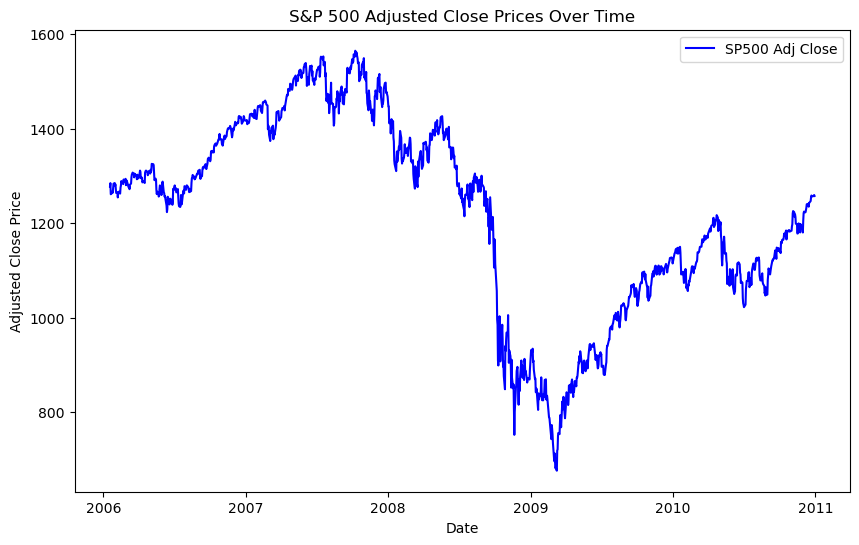

In [28]:
# Assuming sp500_data has 'Date' and 'Adj Close' columns
plt.figure(figsize=(10, 6))
plt.plot(sp500_data.index, sp500_data['Adj Close'], label='SP500 Adj Close', color='blue')

plt.title('S&P 500 Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()
